In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

In [2]:
df = pd.read_csv("/Users/r3alistic/Programming/CoffeeCV/features_v2.csv")
df.head()

,Video_Name,Category,Pull_Duration,Frames_Processed,color_progression,color_consistency,mid_phase_intensity,color_change_rate,flow_steadiness,flow_amplitude,flow_trend,brightness_momentum,brightness_acceleration,brightness_trend,overall_steadiness,phase_uniformity,transition_1_2_smoothness,transition_2_3_smoothness,overall_transition_quality
0,vid_79_good,good,31.24,420,0.268,0.931,19.766,0.00064,0.0431,24,-3.66,0.116,0.1267,2.84,0.5327,0.5563,0.8515,0.8877,0.8696
1,vid_96_good,good,28.84,420,1.462,0.651,17.014,0.00348,0.0000,513,59.23,0.138,0.1371,4.97,0.8736,0.2958,0.8175,0.6142,0.7159
2,vid_80_good,good,29.37,420,0.373,0.944,19.135,0.00089,0.0148,49,-6.14,0.071,0.1068,1.58,0.7127,0.5747,0.7870,0.9006,0.8438
3,vid_43_good,good,28.56,420,1.949,0.512,18.098,0.00464,0.0000,547,-183.51,0.377,0.4554,0.35,0.7781,0.3465,0.5091,0.6284,0.5687
4,vid_14_good,good,27.28,420,2.692,0.412,18.271,0.00641,0.0002,489,-10.58,0.249,0.2940,14.24,0.8252,0.1602,0.5838,0.6767,0.6302


Right now there are no missing values, but just drop them if there are.

In [3]:
df.dropna(axis=0,inplace=True)

In [4]:
df.isna().sum().sum()

0

Now just for sanity, check for duplicates

In [5]:
len(df["Video_Name"]) == len(set(df["Video_Name"]))

True

In [6]:
df.describe()

,Pull_Duration,Frames_Processed,color_progression,color_consistency,mid_phase_intensity,color_change_rate,flow_steadiness,flow_amplitude,flow_trend,brightness_momentum,brightness_acceleration,brightness_trend,overall_steadiness,phase_uniformity,transition_1_2_smoothness,transition_2_3_smoothness,overall_transition_quality
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,27.652135,414.988764,1.220101,0.710685,19.391449,0.003211,0.008592,255.955056,-20.971236,0.206640,0.240602,3.906292,0.830151,0.413567,0.745356,0.760583,0.752975
std,6.321254,23.397987,1.158190,0.219158,2.505274,0.002446,0.023878,187.622742,97.942270,0.144684,0.215301,5.015325,0.104012,0.161976,0.120351,0.108963,0.094912
min,8.640000,256.000000,-1.540000,0.185000,15.010000,0.000080,0.000000,8.000000,-383.970000,0.050000,0.050800,-7.990000,0.449800,0.089100,0.359100,0.358800,0.497200
25%,25.080000,420.000000,0.462000,0.556000,17.202000,0.001260,0.000100,74.000000,-20.660000,0.107000,0.107100,1.580000,0.780000,0.295100,0.658000,0.683100,0.688900
50%,28.900000,420.000000,1.043000,0.767000,19.135000,0.002640,0.001000,211.000000,-2.980000,0.163000,0.168900,3.110000,0.848200,0.398600,0.743700,0.758000,0.760300
75%,30.840000,420.000000,1.696000,0.887000,21.385000,0.004190,0.007200,425.000000,4.210000,0.249000,0.285000,5.630000,0.904100,0.528200,0.842100,0.836200,0.811600
max,46.540000,420.000000,4.546000,0.998000,24.690000,0.010820,0.199200,568.000000,347.070000,0.784000,1.057000,23.120000,0.991300,0.885400,0.991000,0.976600,0.977200


Between Categories, how does each numeric feature look like, on average?

In [19]:
def aggregate_feat(df,features):
    return df.groupby(by=["Category"])[features].mean()

In [21]:
aggregate_feat(df,["flow_amplitude","phase_uniformity","brightness_trend"])

,flow_amplitude,phase_uniformity,brightness_trend
Category,,,
good,262.411765,0.41096,4.072647
under,235.047619,0.42201,3.367619


# Data Preprocessing + Model Building --> Pipeline

(Even with an abysmally low amount of data)

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [39]:
# Separate features and target
X = df.drop(columns=["Category", "Video_Name","Frames_Processed"])
y = df["Category"].to_numpy()

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

predictors_num = list(X.columns)

preprocessor = ColumnTransformer([
    ("scaler",StandardScaler(),predictors_num),
],remainder="drop") #keep "drop". This column transformer will only affect X

# Encode target labels as integers (ex: good = 0, under = 1). OneHotEncoder would be too much here. Just labels in the same column is fine
#pipeline .fit and .predict calls know to do fit_transform on train data and just .transform on test data and unseen data

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42,stratify=y_encoded)

#Using a pipeline no matter what. When we save the best one with joblib, it will have all the preprocessing built into it.
pipeline_1 = Pipeline([
    ("preprocessor",preprocessor),
    ("classifier",LogisticRegression(class_weight='balanced'))
])

#y_test is encoded for future reference testing
pipeline_1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Pull_Duration',
                                                   'color_progression',
                                                   'color_consistency',
                                                   'mid_phase_intensity',
                                                   'color_change_rate',
                                                   'flow_steadiness',
                                                   'flow_amplitude',
                                                   'flow_trend',
                                                   'brightness_momentum',
                                                   'brightness_acceleration',
                                                   'brightness_trend',
                                                   'overall_steadiness',
                                                   'phase_uniformity',
                                                   'transition_1_2_smoothness',
                                                   'transition_2_3_smoothness',
                                                   'overall_transition_quality'])])),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [40]:
y_pred_1 = pipeline_1.predict(X_test)

# Validation Strategies

In [41]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score

## Training Scores - Model 1

In [42]:
y_pred_train_1 = pipeline_1.predict(X_train)

**TPR = Recall = Sensitivity = TP / (TP + FN)**
* "Of all the actually positive cases, how many did we get correct"?
    * True Positive Rate

**Precision = TP / (TP + FP)**
* "Of all of the things the model predicted as positive cases, how many were actually positive?"
    * Positive Predicted Value

In [43]:
print(classification_report(y_train,y_pred_train_1))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91        54
           1       0.68      0.88      0.77        17

    accuracy                           0.87        71
   macro avg       0.82      0.88      0.84        71
weighted avg       0.89      0.87      0.88        71



In [44]:
print("LogReg's Accuracy Score (Training):",accuracy_score(y_train,y_pred_train_1))

LogReg's Accuracy Score (Training): 0.8732394366197183


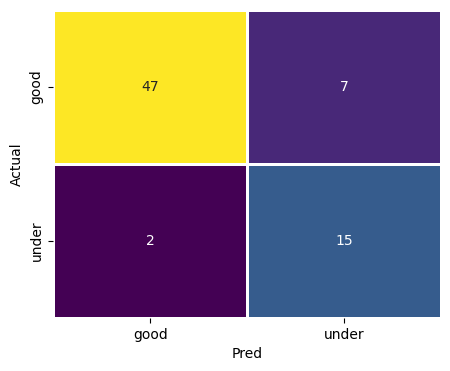

In [45]:
cm = confusion_matrix(y_train,y_pred_train_1)

plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,cmap="viridis",linewidth=0.85,xticklabels=encoder.classes_, yticklabels=encoder.classes_,cbar=False)
plt.xlabel("Pred")
plt.ylabel("Actual")
plt.show()

In [46]:
cv_scores = cross_val_score(pipeline_1,X_train,y_train,cv=5,scoring="accuracy")
print(sorted(cv_scores))
print("mean",cv_scores.mean())

[0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.8, 0.8571428571428571]
mean 0.7457142857142858


## Testing Scores - Model 1

In [47]:
print(classification_report(y_test,y_pred_1))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.25      0.25      0.25         4

    accuracy                           0.67        18
   macro avg       0.52      0.52      0.52        18
weighted avg       0.67      0.67      0.67        18



In [48]:
print("LogReg's Accuracy Score:",accuracy_score(y_test,y_pred_1))

LogReg's Accuracy Score: 0.6666666666666666


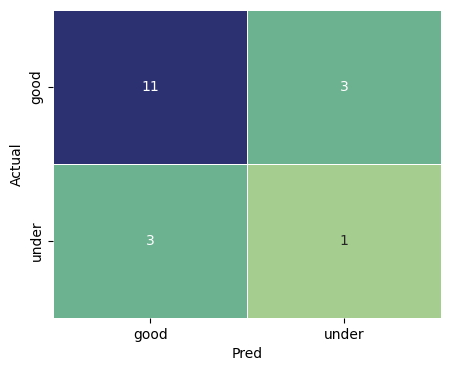

In [49]:
cm = confusion_matrix(y_test,y_pred_1)

plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,cmap="crest",linewidth=0.5,xticklabels=encoder.classes_, yticklabels=encoder.classes_,cbar=False)
plt.xlabel("Pred")
plt.ylabel("Actual")
plt.show()

<p style="color:lightpink">So far, what are the notable feats: 90% train accuracy, more incorrect estimates than we'd like, solid preprocessing, but the model will overfit without enough data. <u>What we need to keep in mind is that training score DOWN and testing score UP is fine and actually what we want anyway.</u></p>

# Feature Selection and Optimization

In [51]:
feature_importance = pipeline_1.named_steps['classifier'].coef_[0]
feature_names = predictors_num
importance_df = pd.DataFrame({'feature': feature_names, 'importance': abs(feature_importance)})
importance_df.sort_values('importance', ascending=False)

,feature,importance
11,overall_steadiness,1.177387
5,flow_steadiness,0.973707
7,flow_trend,0.937449
9,brightness_acceleration,0.886954
8,brightness_momentum,0.866563
2,color_consistency,0.765468
4,color_change_rate,0.497809
10,brightness_trend,0.482301
1,color_progression,0.419807
12,phase_uniformity,0.326297


The above values are the absolute slope coefficients for the decision boundary

In [52]:
df["Category"].value_counts()

Category
good     68
under    21
Name: count, dtype: int64